## Chesapeake Bay Bloom 2025 (July 21) - Looking at the Surface Reflectance Spectra

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Select the date and set the ROI bbox

In [2]:
bbox = (-76.903, 37.873, -75.608, 39.659)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2025-07-22", "2025-07-22"),
    bounding_box = bbox
)

len(results)

1

In [3]:
# look at the file names to make sure they are ok
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250722T173005.L2.SFREFL.V3_1.nc']]

In [4]:
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

This is level 2 data and unlike level 3 data, it has groups. We need to use `open_datatree()` and `merge().

In [5]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [6]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 122, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/25)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    clat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    elat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    csol_z         (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB dask.array<chunksize=(32, 256, 40), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250722T173005.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data2/sdpsoper/vdc/vpu21/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -92.374756
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9688000679016113
    geospatial_bounds:                 POLYGON ((-59.96334 45.67412, -92.3747...

In [7]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 2)})

## Let's open it up!

Let's load up our libraries, and then extract the relevant data we need. 

In [8]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [9]:
# Assign core variables; for convenience during plotting
rhos_da = ds["rhos"]


Let's just do a quick comparison of the two spectral rasters - AVW (focused on spectral shape), and brightness (focused on spectral magnitude).

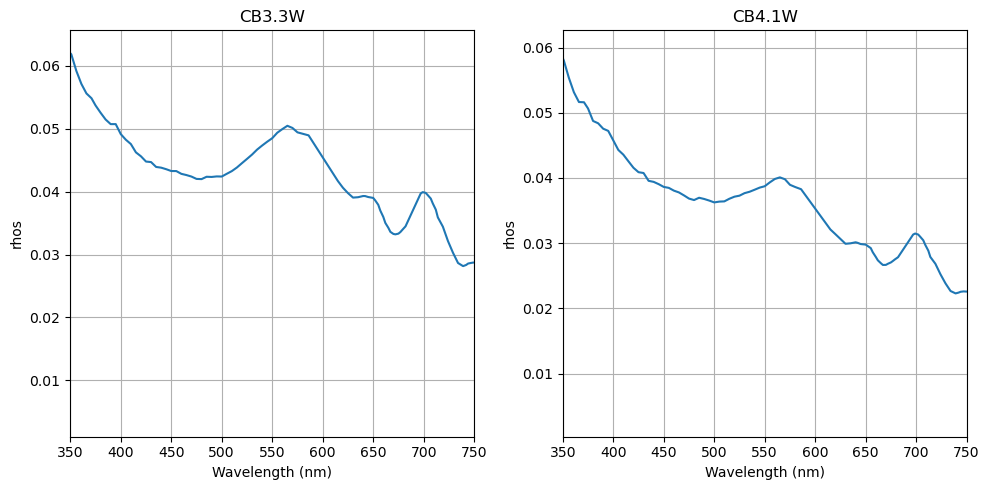

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Stations
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149,-76.4627),
]

# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Number of stations
n_stations = len(stations)

# Create a grid of subplots (adjust rows/cols as needed)
ncols = 2
nrows = 1 # ceil division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, (name, plat, plon) in enumerate(stations):
    # Compute distances to all pixels
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    # Extract spectrum
    spectrum = ds["rhos"].isel(number_of_lines=y, pixels_per_line=x)
    
    # Plot in its own subplot
    ax = axes[i]
    spectrum.plot.line(x="wavelength_3d", ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("rhos")
    #ax.set_ylim(-0.006, 0.002)
    ax.set_xlim(350, 750)
    ax.grid(True)

# Hide any extra subplots if n_stations < nrows*ncols
for j in range(n_stations, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.savefig(
    'SpectraForStations_rhos_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()